# Quick look at NY Phil concert program data

Eamonn Bell, Columbia University `<epb2125@columbia.edu>`

---


Work in progress. Some interesting questions worth asking are bolded if there's anything in the notebook that moves towards a solution.

- What composers tend to get programmed together?
- **Where did the orchestra play?**
- **What does 'composer discovery' look like?** Can we spot faddish composers by the shape of their performance frequency?
- **Who played with whom over the course of the existence of the orchestra?** The social network of performers.
- What are the significant differences between tour and subscription concert programs in general?
- What conductors prefer which works?
- What are the genres of the most-programmed works?
- What time do concerts tend to start at?

---

## Acknowledgements

Thanks to https://github.com/bmcfee for the parsing code. The dataset this notebook is based on was released under CC0 1.0 Universal.

In [2]:
import lxml
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import collections
import glob

from pprint import pprint
from IPython.display import HTML, Image
from lxml import etree, objectify

In [3]:
%matplotlib inline

In [4]:
!git clone https://github.com/nyphilarchive/PerformanceHistory.git

Cloning into 'PerformanceHistory'...
remote: Counting objects: 430, done.
remote: Total 430 (delta 0), reused 0 (delta 0), pack-reused 430
Receiving objects: 100% (430/430), 15.92 MiB | 6.01 MiB/s, done.
Resolving deltas: 100% (319/319), done.
Checking connectivity... done.


In [7]:
# Author: https://github.com/bmcfee/nycphil (Brian McFee)

def parse_programs(programs):
    
    return [parse_program(x) for x in programs]

def parse_program(program):
    
    dispatch = dict(concertInfo=parse_concertInfo,
                    worksInfo=parse_worksInfo)
    data = dict()
    
    for child in program.getchildren():
        if child.tag in dispatch:
            data[child.tag] = dispatch[child.tag](child)
        else:
            data[child.tag] = child.text
            
    return data
            
def parse_concertInfo(concertInfo):
    data = dict()
    
    for child in concertInfo.getchildren():
        data[child.tag] = child.text
    
    return data

def parse_worksInfo(worksInfo):
    
    data = list()
    
    for child in worksInfo.getchildren():
        data.append(parse_work(child))
            
    return data

def parse_work(work):
    
    dispatch = dict(soloists=parse_soloists)
    data = dict()
    
    for child in work.getchildren():
        if child.tag in dispatch:
            data[child.tag] = dispatch[child.tag](child)
        else:
            data[child.tag] = child.text
            
    return data

def parse_soloists(soloists):
    data = list()
    for child in soloists.getchildren():
        data.append(parse_soloist(child))
    return data

def parse_soloist(soloist):
    data = dict()
    
    for child in soloist.getchildren():
        data[child.tag] = child.text
    
    return data

def flatten(d):
    
    works = d.pop('worksInfo', [])
    concertInfo = d.pop('concertInfo', [])
       
    out = []
    for w in works:
        out.append(concertInfo.copy())
        
        # Added this to get soloist's names in. Dirty.
        
        soloists = w.get('soloists', None)
        
        if soloists is not None:
            soloists_names = [s.get('soloistName') for s in soloists if s.get('soloistName') is not None]
            soloists_tsv = "\t".join(soloists_names)
            out[-1].update({'soloists_tsv' : soloists_tsv})
            
        w.pop('soloists', [])
        out[-1].update(d)
        out[-1].update(w)
        
    return out

def load_programs():
    # We need this to handle badly formatted &'s in strings
    parser = etree.XMLParser(recover=True)

    fd = []
    globbed = sorted(glob.glob('./PerformanceHistory/Programs/*.xml'))
    
    for xmlfile in globbed:
        obj = objectify.parse(xmlfile, parser=parser)
        dix = parse_programs(obj.getroot())
        for _ in dix:
            fd.extend(flatten(_))
    df = pd.DataFrame.from_records(fd)
    df['oldDate'] = df['Date']
    df['Date'] = pd.to_datetime(df['Date'])

    return df

In [8]:
df = load_programs()

In [9]:
df.head()

,Date,Location,Time,Venue,composerName,conductorName,eventType,id,interval,movement,orchestra,programID,season,soloists_tsv,workTitle,oldDate
0,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Beethoven, Ludwig van","Hill, Ureli Corelli",Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,NaN,New York Philharmonic,3853,1842-43,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",1842-12-07T05:00:00Z
1,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Weber, Carl Maria Von","Timm, Henry C.",Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,"""Ozean, du Ungeheuer"" (Ocean, thou mighty mons...",New York Philharmonic,3853,1842-43,"Otto, Antoinette",OBERON,1842-12-07T05:00:00Z
2,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Hummel, Johann",NaN,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,NaN,New York Philharmonic,3853,1842-43,"Scharfenberg, William\tHill, Ureli Corelli\tDe...","QUINTET, PIANO, D MINOR, OP. 74",1842-12-07T05:00:00Z
3,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,NaN,NaN,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,Intermission,NaN,New York Philharmonic,3853,1842-43,NaN,NaN,1842-12-07T05:00:00Z
4,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,"Weber, Carl Maria Von","Etienne, Denis G.",Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,NaN,Overture,New York Philharmonic,3853,1842-43,NaN,OBERON,1842-12-07T05:00:00Z


---
## Number of works performed by composers over time

In [10]:
# Get, e.g., top 5 composers by performances of all time

sample_list = list(df.composerName.value_counts()[1:5].index)

In [11]:
sample = df[df.composerName.isin(sample_list)]

In [12]:
all_works = df.groupby(df['Date'].map(lambda x:x.year)).count()
yearly_counts = pd.Series(all_works['id'], index=all_works.index)

In [13]:
yearly_counts.describe()

count     175.000000
mean      940.697143
std       723.043881
min        18.000000
25%       147.000000
50%      1020.000000
75%      1559.000000
max      3014.000000
Name: id, dtype: float64

### Raw counts

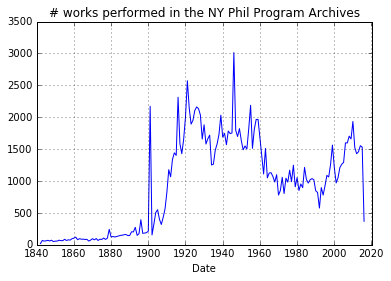

In [14]:
yearly_counts.plot()
plt.title('# works performed in the NY Phil Program Archives')

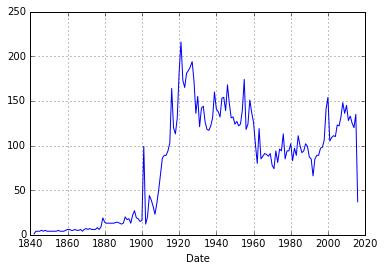

In [15]:
all_programs = df.groupby(df['Date'].map(lambda x:x.year)).programID.nunique()
all_programs.plot()

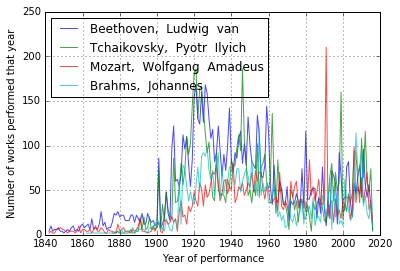

In [17]:
for composer in sample_list:
    one_composer = df[df.composerName == composer]
    aggregate = one_composer.groupby(one_composer['Date'].map(lambda x:x.year)).count()
    composer_counts = pd.Series(aggregate['id'], index=aggregate.index, name=composer)
    composer_counts.plot(legend=True, label=composer, alpha=0.7)

plt.ylabel('Number of works performed that year')
plt.xlabel('Year of performance')

### As a proportion of all works played that year

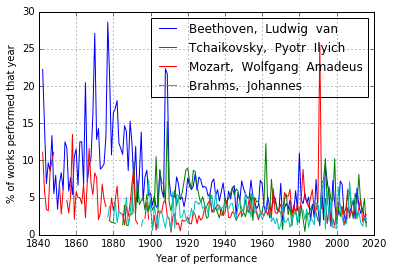

In [18]:
for name in sample_list:
    one_composer = df[df.composerName == name]
    aggregate = one_composer.groupby(one_composer['Date'].map(lambda x:x.year)).count()
    composer_counts = pd.Series(aggregate['id'], index=aggregate.index, name=name)
    composer_counts_prop = composer_counts.divide(yearly_counts) * 100
    composer_counts_prop.plot(legend=True, label=name)

plt.ylabel('% of works performed that year')
plt.xlabel('Year of performance')

### Discovery of new composers

In [20]:
df.composerName.value_counts()[:10]

Wagner,  Richard               9884
Beethoven,  Ludwig  van        8976
Tchaikovsky,  Pyotr  Ilyich    7424
Mozart,  Wolfgang  Amadeus     5234
Brahms,  Johannes              5062
Strauss,  Richard              3248
Mendelssohn,  Felix            2980
Berlioz,  Hector               2788
Bach,  Johann  Sebastian       2756
Dvorak,  Antonín               2430
dtype: int64

In [21]:
def composer_counts_by_name(name):
    composer = df[df.composerName == name]
    aggregate = composer.groupby(composer['Date'].map(lambda x:x.year)).count()
    annual_composer_counts = pd.Series(aggregate['id'], index=aggregate.index, name=name)
    return annual_composer_counts
    
def plot_composer_by_name(name):
    composer_counts_by_name(name).plot(legend=True, label=name)

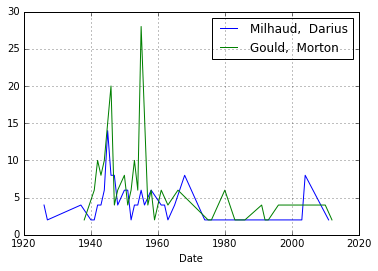

In [22]:
plot_composer_by_name('Milhaud,  Darius')
plot_composer_by_name('Gould,  Morton')

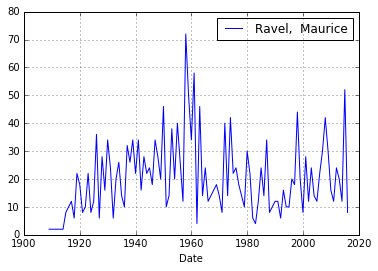

In [23]:
plot_composer_by_name('Ravel,  Maurice')

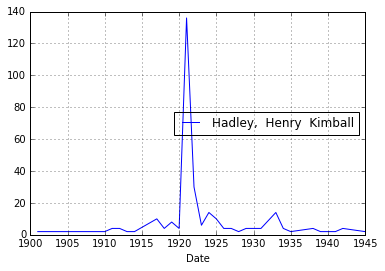

In [24]:
plot_composer_by_name('Hadley,  Henry  Kimball')

In [113]:
hadley = df[df.composerName == 'Hadley,  Henry  Kimball']
hadley.groupby([df.workTitle], sort=True).count()['id'].order(ascending=False).head(10)

workTitle
CULPRIT FAY RHAPSODY, OP. 62                                   60
SALOME, OP. 55                                                 18
IN BOHEMIA                                                     10
OCEAN, THE, OP. 99                                              8
CHINESE SKETCHES - STREETS OF PEKIN                             6
SYMPHONY NO. 3, B MINOR, OP. 60                                 5
SILHOUETTES, OP.77 (ARR. Roberts)                               5
SYMPHONY NO. 4, D MINOR, OP. 64, "NORTH, EAST, SOUTH, WEST"     5
LUCIFER, OP. 66                                                 4
SYMPHONY NO. 2, F MINOR, OP.30 (FOUR SEASONS)                   3
Name: id, dtype: int64

---
## The social network of NY Philharmonic Soloists

In [25]:
soloists = df.soloists_tsv[df.soloists_tsv.notnull()]

In [26]:
soloist_list = list(soloists)

In [27]:
len([s for s in soloists if ('\t' in s) and (';' in s)])

0

In [28]:
tab_separated = [t.split('\t') for t in [s for s in soloists if ('\t') in s]]
semicolon_separated = [t.split(';') for t in [s for s in soloists if (';') in s]]

In [29]:
soloists_split = tab_separated + semicolon_separated

In [30]:
len(soloists_split)

16804

In [31]:
from itertools import combinations

played_with_pairs = []

for collection in soloists_split:
    for pair in combinations(collection, 2):
        played_with_pairs.append(pair)

In [32]:
from collections import Counter
cnt = Counter(played_with_pairs)

In [33]:
top_ten_thou = cnt.most_common(n=10000)

In [34]:
with open('edges.txt', 'w') as f:
    f.write('source;target;weight\n')
    for edge, weight in top_ten_thou:
        try:
            f.write("{}".format(";".join(edge)) + ";{}\n".format(weight))
        except:
            continue

In [35]:
!wc edges.txt

  9756  31006 333138 edges.txt


In [36]:
!head edges.txt

source;target;weight
Smith, Philip;Alessi, Joseph;846
Myers, Philip;Alessi, Joseph;710
Smith, Philip;Myers, Philip;704
New York Philharmonic Principal Brass Quintet;Alessi, Joseph;464
Alessi, Joseph;Baer, Alan;460
New York Philharmonic Principal Brass Quintet;Smith, Philip;424
Smith, Philip;Baer, Alan;396
New York Philharmonic Principal Brass Quintet;Myers, Philip;394
Smith, Philip;Sullivan, Robert;388


Process this with something like `networkx` or Gephi to get something like this:

[pending]

---
## NY Phil on Tour

In [37]:
df.Location.value_counts().head(10)

Manhattan, NY       129948
Philadelphia, PA      2646
Brooklyn, NY          2478
Vail, CO              1134
Washington, DC        1032
Greenvale, NY          722
Baltimore, MD          676
Tokyo, JAPAN           576
London, ENGLAND        482
Bronx, NY              476
dtype: int64

In [38]:
def get_state(location_str):
    splitted = location_str.split(', ')
    if len(splitted) != 2:
        return None
    elif len(splitted[1]) == 2:
        return splitted[1].strip()
    else:
        return None
        
def test_get_state():
    assert get_state('Manhattan, NY') == 'NY'
    assert get_state('Dublin, IRELAND') is None
    assert get_state('foobar,,') is None
    return True

def run_tests():
    assert test_get_state()
    return True

assert run_tests()

In [39]:
df['State'] = df.Location.apply(get_state)

In [40]:
in_usa = df[df.State.notnull()]
out_of_state = df[df.State != 'NY']

In [41]:
decade_state = out_of_state.groupby([(out_of_state.Date.apply(lambda x: x.year)//10)*10,
                                     out_of_state.State]).count()

In [42]:
decade_state.head(10)

Date  Location  Time  Venue  composerName  conductorName  \
Date State                                                             
1890 MA       10        10    10     10            10             10   
1900 DC        4         4     4      4             4              4   
     IA        2         2     2      2             2              2   
     IL       16        16    16     16            16             16   
     IN        4         4     4      4             4              4   
     KS        2         2     2      2             2              2   
     KY        4         4     4      4             4              4   
     MI        6         6     6      6             6              6   
     MN        8         8     8      8             8              8   
     MO        6         6     6      6             6              6   

            eventType  id  interval  movement  orchestra  programID  season  \
Date State                                                                    
1890 MA            10  10         0         2         10         10      10   
1900 DC             4   4         0         2          4          4       4   
     IA             2   2         0         2          2          2       2   
     IL            16  16         0         6         16         16      16   
     IN             4   4         0         2          4          4       4   
     KS             2   2         0         2          2          2       2   
     KY             4   4         0         2          4          4       4   
     MI             6   6         0         4          6          6       6   
     MN             8   8         0         4          8          8       8   
     MO             6   6         0         6          6          6       6   

            soloists_tsv  workTitle  oldDate  State  
Date State                                           
1890 MA                2         10       10     10  
1900 DC                0          4        4      4  
     IA                0          2        2      2  
     IL                4         16       16     16  
     IN                0          4        4      4  
     KS                0          2        2      2  
     KY                0          4        4      4  
     MI                0          6        6      6  
     MN                0          8        8      8  
     MO                4          6        6      6  

[10 rows x 17 columns]

In [43]:
nineties = decade_state.loc[1990]
# Move index to column for use in plotting package later
nineties.reset_index(level=0, inplace=True)

ValueError: cannot insert State, already exists

In [ ]:
twenties = decade_state.loc[1920]
twenties.reset_index(level=0, inplace=True)

Use `folium` for chloropleth visualization

In [ ]:
!wget https://raw.githubusercontent.com/python-visualization/folium/master/examples/us-states.json

In [34]:
def inline_map(m, width=650, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

In [35]:
def state_concert_counts(state_data):
    state_geo = r'us-states.json'
    
    f = folium.Map(location=[48, -102], zoom_start=3, max_zoom=4, min_zoom=3)

    f.geo_json(geo_path=state_geo, data=state_data,
                 data_out='data.json',           
                 columns=['State', 'programID'],
                 key_on='feature.id',
                 fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                 legend_name='Concerts played')
    return inline_map(f)

In [36]:
state_concert_counts(nineties)

In [37]:
state_concert_counts(twenties)

For those of you following along with e.g. GitHub/`ipynbviewer`, this won't render because it depends on some hosted .json files. Screenshots below:

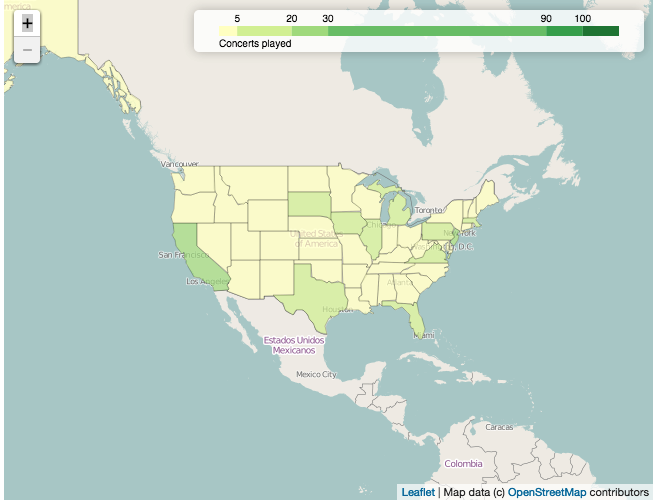

In [38]:
Image('1920s.png')

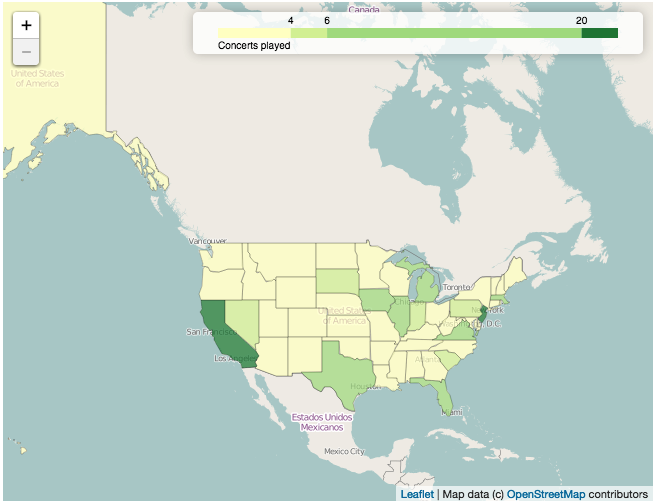

In [39]:
Image('1990s.png')